In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
%matplotlib inline
import matplotlib 
matplotlib.rcParams["font.size"] = 14

In [112]:
# eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 10., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.001
airind = mesh.gridCC[:,2]>0.
actinds = ~airind
# layerind = np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)
layerind = (np.logical_and(mesh.gridCC[:,2]<-20, mesh.gridCC[:,2]>-70.)) & (mesh.gridCC[:,0]<100.)
sigmaInf[airind] = 1e-8
sigmaInf[layerind] = 0.01
eta = np.zeros(mesh.nC)
eta[layerind] = 0.1
tau0, c0 = 0.01, 0.8
tau = np.ones(mesh.nC) * tau0
c = np.ones(mesh.nC) * c0

actmapeta = Maps.InjectActiveCells(mesh, actinds, 0.)
actmaptau = Maps.InjectActiveCells(mesh, actinds, tau0)
actmapc = Maps.InjectActiveCells(mesh, actinds, c0)

wires = Maps.Wires(('eta', actmapeta.nP), ('tau', actmapeta.nP), ('c', actmapeta.nP))

taumap = actmaptau*wires.tau
etamap = actmapeta*wires.eta
cmap = actmapc*wires.c

m = np.r_[eta[actinds], tau[actinds], c[actinds]]

In [113]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
dt = 1.47e-3
rx_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+dt, 'z')
src_ramp = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=dt), loc=srcloc)
survey_ramp = EM.TDEM.Survey([src_ramp])
prb_em_ramp = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
# prb_em_ramp.verbose = True
prb_em_ramp.timeSteps = [(dt/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_ramp.Solver = PardisoSolver
prb_em_ramp.pair(survey_ramp)
# m = np.r_[sigmaInf, etavec, np.log(tauvec), cvec]
F_ramp = prb_em_ramp.fields(sigmaInf)
data_ramp = survey_ramp.dpred(sigmaInf, f=F_ramp)
cur = []
for t in prb_em_ramp.times:
    cur.append(src_ramp.waveform.eval(t))
cur = np.hstack(cur)

In [114]:
# rxloc = np.array([[0., 0., 30.]])
# srcloc = np.array([[0., 0., 30.]])
# tpeak = 2.73e-3
# # t0 = 4.2e-3
# t0 = tpeak + dt
# rx_vtem = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+t0, orientation='z')
# src_vtem = EM.TDEM.Src.CircularLoop([rx_vtem], waveform=EM.TDEM.Src.VTEMWaveform(offTime=t0, peakTime=tpeak, a=3.), loc=srcloc)
# survey_vtem = EM.TDEM.Survey([src_vtem])
# prb_em_vtem = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
# # prb_em_vtem.verbose = True
# prb_em_vtem.timeSteps = [(tpeak/10, 10), ((t0-tpeak)/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
# prb_em_vtem.Solver = PardisoSolver
# prb_em_vtem.pair(survey_vtem)
# F_vtem = prb_em_vtem.fields(sigmaInf)
# data_vtem = survey_vtem.dpred(sigmaInf, f=F_vtem)
# cur = []
# for t in prb_em_vtem.times:
#     cur.append(src_vtem.waveform.eval(t))
# cur = np.hstack(cur)

In [115]:
from simpegEMIP.TDEM import geteref, Problem3D_Inductive, Survey

In [116]:
eref_ramp = geteref(F_ramp[src_ramp, 'eSolution', :], mesh, option=None, tInd=10) 
# eref_vtem = geteref(F_vtem[src_vtem, 'eSolution', :], mesh, option=None, tInd=20) 

In [117]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
rx_ip_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src_ip_ramp = EM.TDEM.Src.CircularLoop([rx_ip_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=0.), loc=srcloc)
dt = 1.47e-3
survey_ip_ramp = Survey([src_ip_ramp])
prb_ip_ramp = Problem3D_Inductive(
    mesh, 
    sigmaInf=sigmaInf, 
    etaMap=etamap, 
    tauMap=taumap, 
    cMap=cmap, 
    actinds = ~airind,
    tlags = [0., dt]
)
prb_ip_ramp.Solver = PardisoSolver
prb_ip_ramp.pair(survey_ip_ramp)
prb_ip_ramp.set_eref(eref_ramp)
ip_ramp_approx = survey_ip_ramp.dpred(m)

>> Compute Sensitivity matrix
[[  0.   0.  30.]] z


In [118]:
survey_ip_ramp.times

array([  2.00000000e-05,   2.25992614e-05,   2.55363308e-05,
         2.88551108e-05,   3.26052096e-05,   3.68426828e-05,
         4.16308710e-05,   4.70413468e-05,   5.31549847e-05,
         6.00631698e-05,   6.78691638e-05,   7.66896488e-05,
         8.66564710e-05,   9.79186121e-05,   1.10644416e-04,
         1.25024104e-04,   1.41272620e-04,   1.59632844e-04,
         1.80379218e-04,   2.03821856e-04,   2.30311170e-04,
         2.60243117e-04,   2.94065111e-04,   3.32282716e-04,
         3.75467199e-04,   4.24264069e-04,   4.79402730e-04,
         5.41707381e-04,   6.12109336e-04,   6.91660945e-04,
         7.81551325e-04,   8.83124136e-04,   9.97897661e-04,
         1.12758751e-03,   1.27413224e-03,   1.43972238e-03,
         1.62683312e-03,   1.83826135e-03,   2.07716744e-03,
         2.34712250e-03,   2.65216175e-03,   2.99684483e-03,
         3.38632399e-03,   3.82642105e-03,   4.32371449e-03,
         4.88563770e-03,   5.52059018e-03,   6.23806303e-03,
         7.04878086e-03,

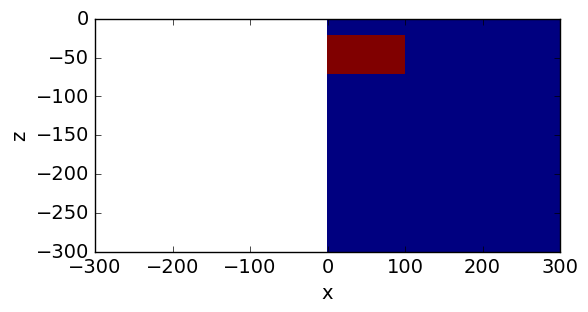

In [119]:
mesh.plotImage(prb_ip_ramp.eta)
plt.xlim(-300, 300)
plt.ylim(-300, 0)
plt.gca().set_aspect('equal')

In [120]:
data_ramp_approx = data_em_ramp + ip_ramp_approx
# data_vtem_approx = data_em_vtem + ip_vtem_approx

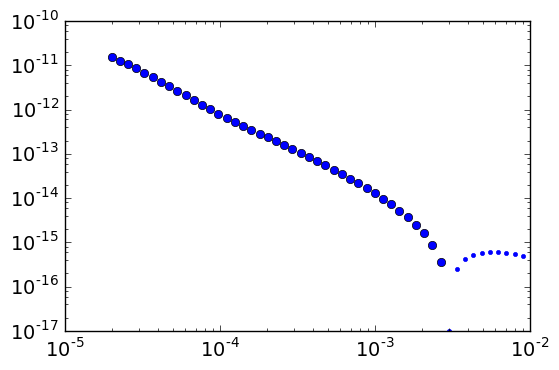

In [121]:
plt.loglog(rx_ip_ramp.times, -data_ramp_approx, 'bo')
plt.loglog(rx_ip_ramp.times, data_ramp_approx, 'b.')